In [11]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/bosonic/bqec@huikhoon')

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt
import constant as constant
import pickle

%config InlineBackend.figure_formats = ['svg']

# Approximations in transmon simulation

### Phys. Rev. Applied 16, 054039

The transmon can be comprehensively described by the isolated qubit CPB Hamiltonian,

\begin{align*}
    \hat{H}_{anc} = 4E_C(\hat{n}-n_g)^2 - E_J\cos\hat{\phi}
\end{align*}

When capacitively coupled to a cavity, the full (most faithful) Hamiltonian reads

\begin{align}
    \hat{H} = \omega_a \hat{a}^\dagger\hat{a} + H_{anc} - 2e\hat{n}V_a(\hat{a}^\dagger + \hat{a})
\end{align}

## Duffing oscillator ($\text{DO}_K$)

Transmon is a pertubed harmonic oscillator. Condition: $E_J/E_C \gg 1$, i.e. $\Delta \phi \ll 1$. The consine term is treated as a series truncated at $K$ order,

\begin{align}
    \cos\hat{\phi} = \sum_{k=0}^{K} \dfrac{(-1)^k \hat{\phi}^{\ 2k}}{(2k)!}
\end{align}

Cost: breakdown of periodic boundary condition. Let the number and phase operator be

\begin{align}
    \hat{n} = \dfrac{i}{2\sqrt{\eta}}(\hat{c}^\dagger - \hat{c}),\\
    \hat{\phi} = \sqrt{\eta}\ (\hat{c}^\dagger + \hat{c}),\\
    \eta = \sqrt{2E_C/E_J}
\end{align}

Then the family of uncoupled Hamiltonian is $K > 1$

\begin{align}
    \hat{H}_{\text{DO}_{K}} = \sqrt{8E_CE_J}(\hat{c}^\dagger\hat{c} + \dfrac{1}{2}) - E_J - E_J\sum_{k=2}^{K} \left(\dfrac{2E_C}{E_J}\right)^{k/2} \dfrac{(-1)^k\ (\hat{c}^\dagger + \hat{c})^{\ 2k}}{(2k)!}
\end{align}

The case $K=2$ (plus interaction) is what we've used in the previous RWA simulation, plus an irrelevant constant.

\begin{align}
    \hat{H}_{\text{DO}_{2}} = \sqrt{8E_CE_J}(\hat{c}^\dagger\hat{c} + \dfrac{1}{2}) - E_J - \dfrac{E_C}{12}(\hat{c} +\hat{c}^\dagger)^4 + \omega_a \hat{a}^\dagger\hat{a} + i g_{ac}(\hat{c}^{\dagger}- \hat{c})(\hat{a}^\dagger + \hat{a})
\end{align}

Their experimental collaborators told them that $K=2$ is not good enough. So they introduced $K=3$.

\begin{align}
    \hat{H}_{\text{DO}_{3}} = \sqrt{8E_CE_J}(\hat{c}^\dagger\hat{c} + 1/2) - E_J - \dfrac{E_C}{12}(\hat{c} +\hat{c}^\dagger)^4 + \dfrac{E_J}{720}\left(\dfrac{2E_C}{E_J}\right)^{3/2}(\hat{b}+\hat{b}^\dagger)^6 + \omega_a \hat{a}^\dagger\hat{a} + i g_{ac}(\hat{c}^{\dagger}- \hat{c})(\hat{a}^\dagger + \hat{a})
\end{align}

When is not good enough? The sextic term becomes relevant when $E_J/E_C$ is not $\gg 1$.

Now we add the control $V_g(t)$. 

\begin{align}
    H_d(t) &= \hat{n}V_g(t),\\
           &= \dfrac{i}{2\sqrt{\eta}}(\hat{c}^\dagger-\hat{c})V_g(t),
\end{align}

where the drive pulse could be taken as a sum of sinusoidal carrier frequency modulated by a scaled envelope function,

\begin{align}
    V_g(t) &= \sum_i \Omega_i(t) \cos(\omega_{d,i} t + \varphi_i),\\
           &= \sum_i \dfrac{1}{2} \left({\Omega_i}^*(t) e^{i \omega_{d,i} t} + \Omega_i(t) e^{-i \omega_{d,i} t}\right)
\end{align}

in which $\Omega_{i} := \Omega_{i}e^{i\varphi_i}$.

# Constructing time-dependent Hamiltonian 
#### (using `.cosm()` method / $K=2$ / $K=3$)

In [2]:
nA = 30
nC = 30

In [3]:
# Transmon
omega_10 = 4.936
alpha = 0.168
omega_c = omega_10 + alpha

# Ratios
r0 = 1
r1 = 9.64 # delta_a / alpha
r2 = 0.26 # delta_d / alpha
r3 = 0 # Omega_d / delta_d
r4 = 0.064 # g_ac / delta_a

# Cavity
delta_a = r1 * alpha 
omega_a = omega_10 + delta_a

# EJ, EC from pertubation theory
EC = alpha 
EJ = r0 * omega_c**2 / (8 * alpha)
eta = np.sqrt(2 * EC / EJ)

# Coupling
g_ac = r4 * delta_a

# Drive
delta_d = r2 * alpha 
omega_d = omega_10 + delta_d

In [4]:
a = qt.tensor(qt.destroy(nA), qt.qeye(nC))
c = qt.tensor(qt.qeye(nA), qt.destroy(nC))

number_op = (1j / (2 * eta)) * (c.dag() - c)
phase_op = np.sqrt(eta) * (c.dag() + c)

H_cav = omega_a * a.dag() * a

H_anc_f = 4 * EC * number_op**2 - EJ * phase_op.cosm()

H_anc_2 = 4 * EC * number_op**2 - EJ * (1 - 1/2 * phase_op**2 + 1/24 * phase_op**4)

H_anc_3 = 4 * EC * number_op**2 - EJ * (1 - 1/2 * phase_op**2 + 1/24 * phase_op**4 - 1/math.factorial(6) * phase_op**6)

H_int = 1j * np.real(g_ac) * (c.dag() - c) * (a.dag() + a)

H_f = H_cav + H_anc_f + H_int
H_2 = H_cav + H_anc_2 + H_int
H_3 = H_cav + H_anc_3 + H_int

In [5]:
def H_d0(dim_a=nA, dim_c=nC):
    
    a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
    c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

    return (1j / (2 * np.sqrt(eta))) * (c.dag() - c)

def Hd0_coeffs(t, args):

    A = args['A']
    tau = args['tau']
    omega_d = args['omega_d']
    theta_d = args['theta_d']
    sigma = tau / 4

    Omega_0 = A * np.exp(-0.5 * ((tau/2) / sigma)**2)
    Omega_t = A * np.exp(-0.5 * ((t - tau / 2) / sigma)**2)

    return ((Omega_t - Omega_0) / (1 - Omega_0)) * np.cos(omega_d * t + theta_d)

In [6]:
init_state = qt.tensor(qt.coherent(nA, 1.5), qt.fock(nC, 0))

time_sim_max = 10000
time_sim = np.linspace(0, time_sim_max, 10000)

output_f_no_drive_1 = qt.mesolve(H=H_f, rho0=init_state, tlist=time_sim, c_ops=None, e_ops=None,
                                 options={'progress_bar':'text', 'nsteps':10000})

# output_2_no_drive_1 = qt.mesolve(H_static(2), psi0, time_sim, [], [], ProgressBar=True)
# output_3_no_drive_1 = qt.mesolve(H_static(3), psi0, time_sim, [], [], ProgressBar=True)

10.0%. Run time: 3303.23s. Est. time left: 00:08:15:25
20.0%. Run time: 6367.74s. Est. time left: 00:07:04:27
30.0%. Run time: 9629.52s. Est. time left: 00:06:14:25
40.0%. Run time: 12753.57s. Est. time left: 00:05:18:47
50.0%. Run time: 15847.21s. Est. time left: 00:04:24:04
60.0%. Run time: 18502.01s. Est. time left: 00:03:25:31
70.0%. Run time: 20352.30s. Est. time left: 00:02:25:19
80.0%. Run time: 22277.36s. Est. time left: 00:01:32:46
90.0%. Run time: 24346.18s. Est. time left: 00:00:45:02
100.0%. Run time: 26120.79s. Est. time left: 00:00:00:00
Total run time: 26120.80s


In [7]:
init_state = qt.tensor(qt.coherent(nA, 1.5), qt.fock(nC, 0))

time_sim_max = 10000
time_sim = np.linspace(0, time_sim_max, 10000)

output_2_no_drive_1 = qt.mesolve(H=H_2, rho0=init_state, tlist=time_sim, c_ops=None, e_ops=None,
                                 options={'progress_bar':'text', 'nsteps':10000})

# output_2_no_drive_1 = qt.mesolve(H_static(2), psi0, time_sim, [], [], ProgressBar=True)
# output_3_no_drive_1 = qt.mesolve(H_static(3), psi0, time_sim, [], [], ProgressBar=True)

10.0%. Run time: 302.24s. Est. time left: 00:00:45:19
20.0%. Run time: 637.56s. Est. time left: 00:00:42:29
30.0%. Run time: 973.10s. Est. time left: 00:00:37:50
40.0%. Run time: 1308.31s. Est. time left: 00:00:32:42
50.0%. Run time: 1643.55s. Est. time left: 00:00:27:23
60.0%. Run time: 1886.70s. Est. time left: 00:00:20:57
70.0%. Run time: 2126.98s. Est. time left: 00:00:15:11
80.0%. Run time: 2367.30s. Est. time left: 00:00:09:51
90.0%. Run time: 2607.17s. Est. time left: 00:00:04:49
100.0%. Run time: 2848.75s. Est. time left: 00:00:00:00
Total run time: 2848.75s


In [8]:
init_state = qt.tensor(qt.coherent(nA, 1.5), qt.fock(nC, 0))

time_sim_max = 10000
time_sim = np.linspace(0, time_sim_max, 10000)

output_3_no_drive_1 = qt.mesolve(H=H_3, rho0=init_state, tlist=time_sim, c_ops=None, e_ops=None,
                                 options={'progress_bar':'text', 'nsteps':10000})

# output_2_no_drive_1 = qt.mesolve(H_static(2), psi0, time_sim, [], [], ProgressBar=True)
# output_3_no_drive_1 = qt.mesolve(H_static(3), psi0, time_sim, [], [], ProgressBar=True)

10.0%. Run time: 349.81s. Est. time left: 00:00:52:27
20.0%. Run time: 732.31s. Est. time left: 00:00:48:48
30.0%. Run time: 1113.42s. Est. time left: 00:00:43:17
40.0%. Run time: 1491.91s. Est. time left: 00:00:37:17
50.0%. Run time: 1856.58s. Est. time left: 00:00:30:56
60.0%. Run time: 2121.87s. Est. time left: 00:00:23:34
70.0%. Run time: 2388.76s. Est. time left: 00:00:17:03
80.0%. Run time: 2653.51s. Est. time left: 00:00:11:03
90.0%. Run time: 2916.26s. Est. time left: 00:00:05:23
100.0%. Run time: 3178.56s. Est. time left: 00:00:00:00
Total run time: 3178.56s


In [24]:
full_H_no_drive_1_states = []
for idx in range(len(output_f_no_drive_1.states)):
    full_H_no_drive_1_states.append(output_f_no_drive_1.states[idx].full())
full_H_no_drive_1_states = np.array(full_H_no_drive_1_states)

with open('./transmon_approx/numerical_data/full_H_no_drive_1_states.pkl', 'wb') as f:
    pickle.dump(full_H_no_drive_1_states, f)

In [25]:
K2_H_no_drive_1_states = []
for idx in range(len(output_2_no_drive_1.states)):
    K2_H_no_drive_1_states.append(output_2_no_drive_1.states[idx].full())
K2_H_no_drive_1_states = np.array(K2_H_no_drive_1_states)

with open('./transmon_approx/numerical_data/K2_H_no_drive_1_states.pkl', 'wb') as f:
    pickle.dump(K2_H_no_drive_1_states, f)

In [26]:
K3_H_no_drive_1_states = []
for idx in range(len(output_3_no_drive_1.states)):
    K3_H_no_drive_1_states.append(output_3_no_drive_1.states[idx].full())
K3_H_no_drive_1_states = np.array(K3_H_no_drive_1_states)

with open('./transmon_approx/numerical_data/K3_H_no_drive_1_states.pkl', 'wb') as f:
    pickle.dump(K3_H_no_drive_1_states, f)

In [30]:
f_2f_no_drive_1 = []
f_3f_no_drive_1 = []

for idx, _ in enumerate(time_sim):
    f_2f_no_drive_1.append(qt.fidelity(output_f_no_drive_1.states[idx], output_2_no_drive_1.states[idx]))
    f_3f_no_drive_1.append(qt.fidelity(output_f_no_drive_1.states[idx], output_3_no_drive_1.states[idx]))

f_2f_no_drive_1 = np.array(f_2f_no_drive_1)
f_3f_no_drive_1 = np.array(f_3f_no_drive_1)

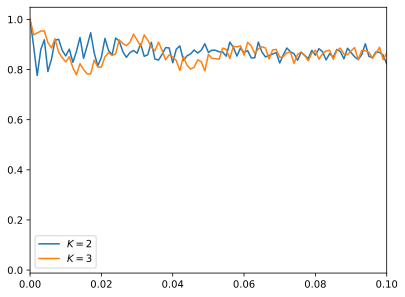

In [32]:
plt.plot(time_sim * 1e-9 / 1e-6, f_2f_no_drive_1, label='$K=2$')
plt.plot(time_sim * 1e-9 / 1e-6, f_3f_no_drive_1, label='$K=3$')
plt.xlim([0, 0.1])
plt.legend()